# Ultrasound variability analysis

This notebook investigates sources of variability in ultrasound measurements.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from math import sqrt
from statsmodels.stats.anova import anova_lm
from ipywidgets import widgets, interact
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Import and clean the data.

In [2]:
df = pd.read_excel('ultrasound_variability.xls', na_values='null')
df = df.drop('notes',axis=1)
df = df.dropna()
df['observer'] = df['observer'].str.lower()
df['difference'] = df['measured_distance_mm'] - df['actual_distance_mm']
df['start_pin_cm'] = df['start_pin_cm'].astype(int)

## Absolute variability

The distribution of differences suggests a mean difference of less than zero, i.e. all measurements generally underestimated actual distance. 

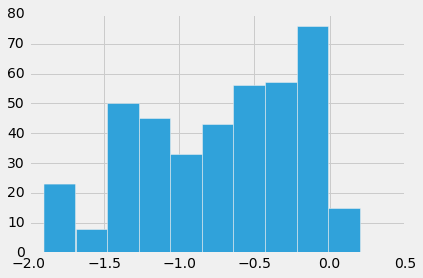

In [3]:
df['difference'].hist();

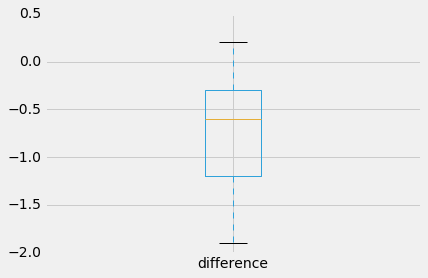

In [4]:
df.boxplot(column='difference',return_type='dict');

In [5]:
overall_difference_stats = {}
overall_difference_stats['median'] = df['difference'].median()
overall_difference_stats['lower_quartile'] = df['difference'].quantile(.25)
overall_difference_stats['upper_quartile'] = df['difference'].quantile(.75)
overall_difference_stats['min'] = df['difference'].min()
overall_difference_stats['max'] = df['difference'].max()
overall_difference_stats['iqr'] = overall_difference_stats['upper_quartile'] - overall_difference_stats['lower_quartile']
overall_difference_stats['mean'] = df['difference'].mean()
overall_difference_stats['std'] = df['difference'].std()
overall_difference_stats['n'] = df['difference'].count()
overall_difference_stats['se'] = overall_difference_stats['std'] / float(sqrt(overall_difference_stats['n']))
overall_difference_stats['fifth_centile'] = df['difference'].quantile(.05)
overall_difference_stats['ninety_fifth_centile'] = df['difference'].quantile(.95)
overall_difference_stats['ninety_percent_range'] = overall_difference_stats['ninety_fifth_centile'] - overall_difference_stats['fifth_centile']
overall_difference_stats

{'fifth_centile': -1.7000000000000028,
 'iqr': 0.90000000000000213,
 'lower_quartile': -1.2000000000000028,
 'max': 0.19999999999999929,
 'mean': -0.7302955665024633,
 'median': -0.6000000000000014,
 'min': -1.8999999999999986,
 'n': 406,
 'ninety_fifth_centile': -0.099999999999999645,
 'ninety_percent_range': 1.6000000000000032,
 'se': 0.025451868917735335,
 'std': 0.5128409483949837,
 'upper_quartile': -0.30000000000000071}

The standard deviation of measurements generally was +- 0.5 mm. **90% of the measurements were +- 0.8 mm**. 

Create data matrix for statsmodels required format.

In [6]:
y, X = dmatrices('difference ~ C(observer) + C(preset) + C(phantom) + C(machine) + C(start_pin_cm) + C(actual_distance_mm)', data=df, return_type='dataframe')

## Absolute Error

Calculate the difference between measured and actual distance.

In [7]:
model = sm.OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     91.32
Date:                Mon, 24 Oct 2016   Prob (F-statistic):          8.75e-121
Time:                        21:09:33   Log-Likelihood:                 12.100
No. Observations:                 406   AIC:                             9.800
Df Residuals:                     389   BIC:                             77.91
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -0.7031      0.074     -9.495      0.000        -0.849    -0.558
C(observer)[T.j]               -0.0707      0.028     -2.549      0.011        -0.125    -0.016
C(observer)[T.s]               -0.0946      0.031     -3.006      0.003        -0.157    -0.033
C(preset)[T.nuchal_no_proc]     0.0059      0.022      0.268      0.789        -0.038     0.049
C(preset)[T.ob-nuchal]          0.0300      0.019      1.541      0.124        -0.008     0.068
C(phantom)[T.gammex_404]        0.5074      0.033     15.540      0.000         0.443     0.572
C(machine)[T.toshiba_xario]     0.0359      0.020      1.798      0.073        -0.003     0.075
C(start_pin_cm)[T.2]            0.3273      0.059      5.540      0.000         0.211     0.443
C(start_pin_cm)[T.3]            0.3734      0.073      5.149      0.000         0.231     0.516
C(start_pin_cm)[T.4]            0.3582      0.081      4.398      0.000         0.198     0.518
C(start_pin_cm)[T.5]            0.3894      0.081      4.782      0.000         0.229     0.550
C(actual_distance_mm)[T.20]    -0.3039      0.056     -5.470      0.000        -0.413    -0.195
C(actual_distance_mm)[T.30]    -0.4733      0.042    -11.241      0.000        -0.556    -0.391
C(actual_distance_mm)[T.40]    -0.7032      0.056    -12.656      0.000        -0.812    -0.594
C(actual_distance_mm)[T.50]    -0.8544      0.056    -15.239      0.000        -0.965    -0.744
C(actual_distance_mm)[T.60]    -0.8305      0.056    -14.946      0.000        -0.940    -0.721
C(actual_distance_mm)[T.70]    -0.8795      0.055    -15.955      0.000        -0.988    -0.771
C(actual_distance_mm)[T.80]    -0.9287      0.075    -12.363      0.000        -1.076    -0.781
==============================================================================
Omnibus:                       83.708   Durbin-Watson:                   0.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.394
Skew:                           0.971   Prob(JB):                     2.09e-51
Kurtosis:                       6.166   Cond. No.                     9.01e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [8]:
an = anova_lm(res)
an

,df,sum_sq,mean_sq,F,PR(>F)
C(observer),2.0,0.480999,0.240499,4.177324,1.603315e-02
C(preset),2.0,5.954849,2.977424,51.716019,1.212947e-20
C(phantom),1.0,13.902963,13.902963,241.485876,1.051105e-42
C(machine),1.0,0.003458,0.003458,0.060060,8.065299e-01
C(start_pin_cm),4.0,40.276617,10.069154,174.894987,1.500447e-85
C(actual_distance_mm),7.0,23.522410,3.360344,58.367104,6.929030e-57
Residual,389.0,22.395731,0.057573,NaN,NaN


In [9]:
anova_variability = {}
total_sum_sq = float(an.sum_sq.sum())
anova_variability['preset_var_prop'] = an.sum_sq['C(preset)'] / total_sum_sq
anova_variability['machine_var_prop'] = an.sum_sq['C(machine)'] / total_sum_sq
anova_variability['phantom_var_prop'] = an.sum_sq['C(phantom)'] / total_sum_sq
anova_variability['actual_distance_var_prop'] = an.sum_sq['C(actual_distance_mm)'] / total_sum_sq
anova_variability['start_pin_var_prop'] = an.sum_sq['C(start_pin_cm)'] / total_sum_sq
anova_variability['unaccounted_var_prop'] = an.sum_sq['Residual'] / total_sum_sq
anova_variability

{'actual_distance_var_prop': 0.22079093977989753,
 'machine_var_prop': 3.2456549862040519e-05,
 'phantom_var_prop': 0.13049888483486566,
 'preset_var_prop': 0.055894638529203573,
 'start_pin_var_prop': 0.3780527644902591,
 'unaccounted_var_prop': 0.21021546727310902}

The ANOVA analysis suggests that the sources of largest variability is the start pin from which measurements are taken at around **38%** as well as the actual distance measured which accounts for around **22%**. The type of phantom does also contribute to the variability of measurements although to a much smaller extent at around **13%** as well. This is in comparison to the natural unaccounted variation of around **21%**. 

## Analysis of factors affecting difference between actual and measured distances

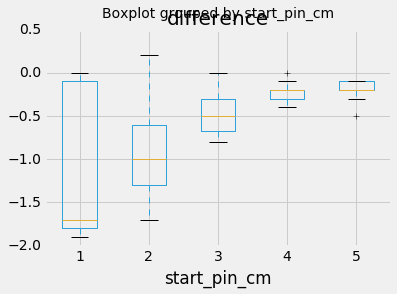

In [10]:
df.boxplot(column='difference', by='start_pin_cm');

The boxplot above suggests that measurements taken from pins 4 and 5 are far less variable than from pins 1, 2 and 3. 

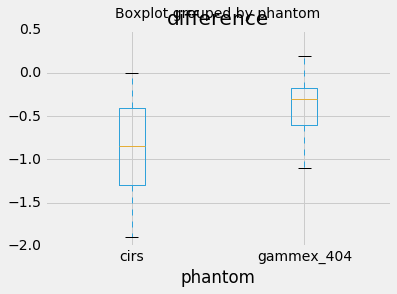

In [11]:
df.boxplot(column='difference', by='phantom');

Variability of measurements using the CIRS phantom is slightly higher than the gammex but the most striking feature is that the CIRS phantom consistently underestimates distance relative to the gammex. 

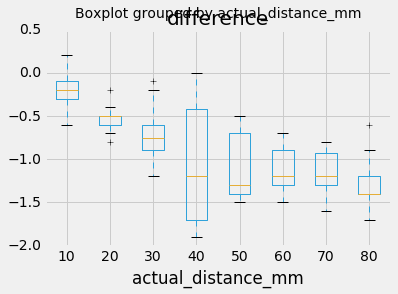

In [12]:
df.boxplot(column='difference',by='actual_distance_mm');

It is clear that there is a relationship between length of measurement made in the phantom and the magnitude of the error. 

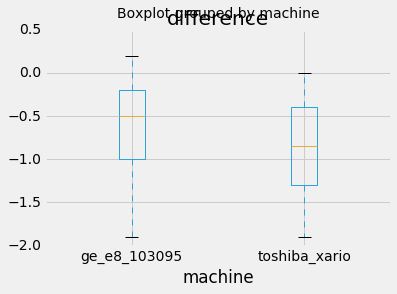

In [13]:
df.boxplot(column='difference', by='machine');

There doesn't seem to be a significant difference in the difference between machines.

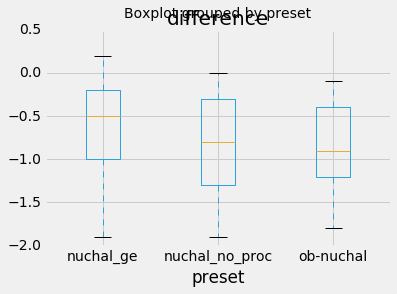

In [14]:
df.boxplot(column='difference', by='preset');

There isn't a significant difference in the variability measurements obtained using difference presets. 

## Analysis of factors affecting percentage differences between actual and measured error

In [15]:
df['percentage_difference'] = (df['measured_distance_mm'] - df['actual_distance_mm']) / df['actual_distance_mm']

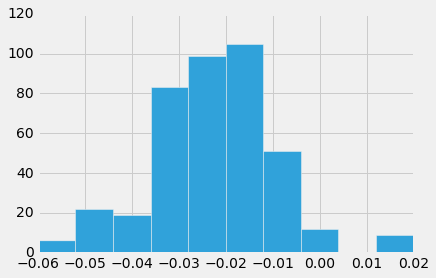

In [16]:
df['percentage_difference'].hist();

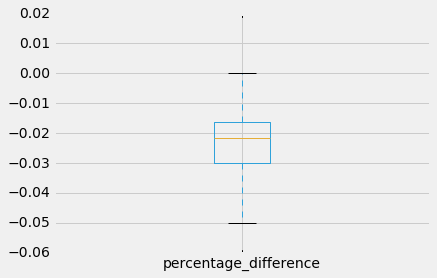

In [17]:
df.boxplot(column='percentage_difference', return_type='dict');

In [18]:
y, X = dmatrices('percentage_difference ~ C(observer) + C(preset) + C(phantom) + C(machine) + C(start_pin_cm) + C(actual_distance_mm)', data=df, return_type='dataframe')

In [19]:
model = sm.OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     percentage_difference   R-squared:                       0.409
Model:                               OLS   Adj. R-squared:                  0.385
Method:                    Least Squares   F-statistic:                     16.82
Date:                   Mon, 24 Oct 2016   Prob (F-statistic):           1.89e-35
Time:                           21:09:34   Log-Likelihood:                 1294.7
No. Observations:                    406   AIC:                            -2555.
Df Residuals:                        389   BIC:                            -2487.
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0373      0.003    -11.854      0.000        -0.043    -0.031
C(observer)[T.j]               -0.0026      0.001     -2.226      0.027        -0.005    -0.000
C(observer)[T.s]               -0.0039      0.001     -2.891      0.004        -0.006    -0.001
C(preset)[T.nuchal_no_proc]     0.0007      0.001      0.725      0.469        -0.001     0.003
C(preset)[T.ob-nuchal]          0.0010      0.001      1.270      0.205        -0.001     0.003
C(phantom)[T.gammex_404]        0.0177      0.001     12.743      0.000         0.015     0.020
C(machine)[T.toshiba_xario]     0.0017      0.001      2.040      0.042      6.23e-05     0.003
C(start_pin_cm)[T.2]            0.0082      0.003      3.262      0.001         0.003     0.013
C(start_pin_cm)[T.3]            0.0108      0.003      3.522      0.000         0.005     0.017
C(start_pin_cm)[T.4]            0.0103      0.003      2.978      0.003         0.003     0.017
C(start_pin_cm)[T.5]            0.0134      0.003      3.882      0.000         0.007     0.020
C(actual_distance_mm)[T.20]    -0.0036      0.002     -1.543      0.124        -0.008     0.001
C(actual_distance_mm)[T.30] -3.497e-05      0.002     -0.020      0.984        -0.004     0.003
C(actual_distance_mm)[T.40]     0.0009      0.002      0.390      0.697        -0.004     0.006
C(actual_distance_mm)[T.50]     0.0027      0.002      1.144      0.253        -0.002     0.007
C(actual_distance_mm)[T.60]     0.0069      0.002      2.905      0.004         0.002     0.011
C(actual_distance_mm)[T.70]     0.0088      0.002      3.781      0.000         0.004     0.013
C(actual_distance_mm)[T.80]     0.0120      0.003      3.758      0.000         0.006     0.018
==============================================================================
Omnibus:                       42.781   Durbin-Watson:                   1.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.288
Skew:                           0.399   Prob(JB):                     2.32e-33
Kurtosis:                       5.872   Cond. No.                     9.01e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
an = anova_lm(res)
an

,df,sum_sq,mean_sq,F,PR(>F)
C(observer),2.0,0.000691,0.000345,3.326951,3.692681e-02
C(preset),2.0,0.002912,0.001456,14.024332,1.314854e-06
C(phantom),1.0,0.016857,0.016857,162.390986,2.516558e-31
C(machine),1.0,0.000427,0.000427,4.108868,4.334045e-02
C(start_pin_cm),4.0,0.003831,0.000958,9.225589,3.945411e-07
C(actual_distance_mm),7.0,0.003504,0.000501,4.821907,3.176907e-05
Residual,389.0,0.040381,0.000104,NaN,NaN


In [21]:
anova_variability = {}
total_sum_sq = float(an.sum_sq.sum())
anova_variability['preset_var_prop'] = an.sum_sq['C(preset)'] / total_sum_sq
anova_variability['machine_var_prop'] = an.sum_sq['C(machine)'] / total_sum_sq
anova_variability['phantom_var_prop'] = an.sum_sq['C(phantom)'] / total_sum_sq
anova_variability['actual_distance_var_prop'] = an.sum_sq['C(actual_distance_mm)'] / total_sum_sq
anova_variability['start_pin_var_prop'] = an.sum_sq['C(start_pin_cm)'] / total_sum_sq
anova_variability['unaccounted_var_prop'] = an.sum_sq['Residual'] / total_sum_sq
anova_variability

{'actual_distance_var_prop': 0.051075032255922227,
 'machine_var_prop': 0.0062174729955145423,
 'phantom_var_prop': 0.24572745504050086,
 'preset_var_prop': 0.042442792726914966,
 'start_pin_var_prop': 0.055840060192942763,
 'unaccounted_var_prop': 0.58862860815826701}

The only significant factors that are related to the percentage error seem to be the phantom used and, to some extent the start_pin and distance measured. 

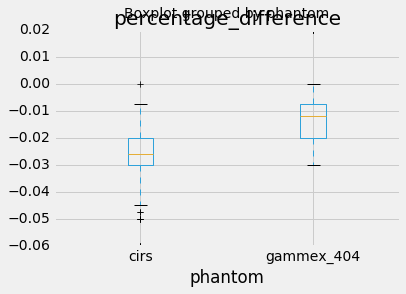

In [22]:
df.boxplot(column='percentage_difference', by='phantom');

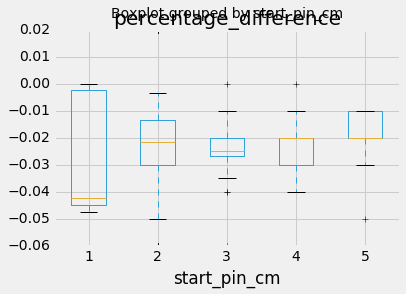

In [23]:
df.boxplot(column='percentage_difference', by='start_pin_cm');

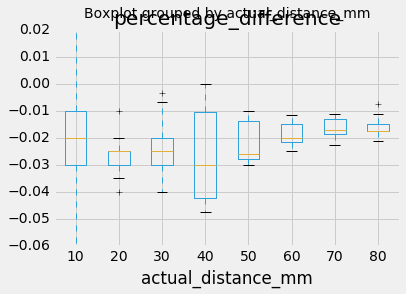

In [24]:
df.boxplot(column='percentage_difference', by='actual_distance_mm');

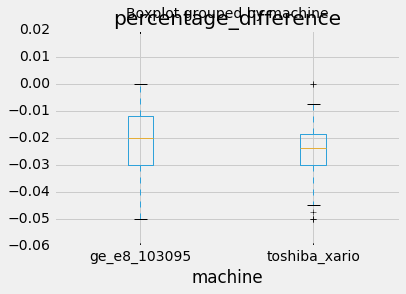

In [25]:
df.boxplot(column='percentage_difference', by='machine');

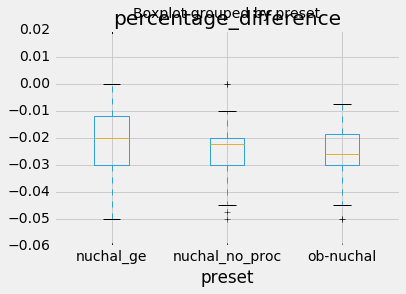

In [26]:
df.boxplot(column='percentage_difference', by='preset');

Question. Does the issue of start_pin and distance measurement variability apply to one of the phantom test objects more than the other?

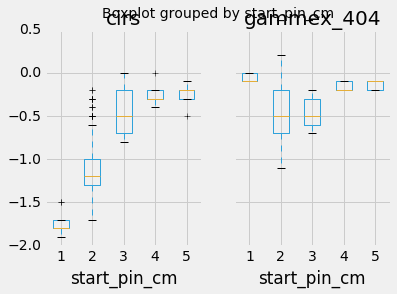

In [27]:
phantom_groups = df.groupby('phantom')
phantom_groups.boxplot(column='difference', by='start_pin_cm');

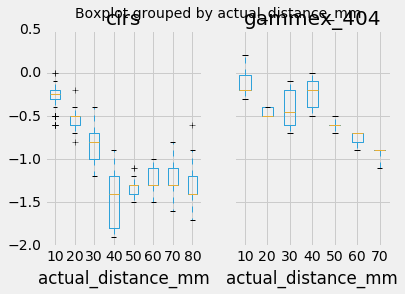

In [28]:
phantom_groups.boxplot(column='difference', by='actual_distance_mm');

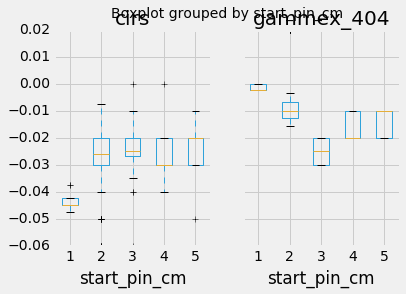

In [29]:
phantom_groups.boxplot(column='percentage_difference', by='start_pin_cm');

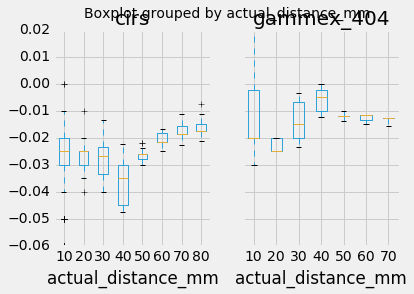

In [30]:
phantom_groups.boxplot(column='percentage_difference', by='actual_distance_mm');

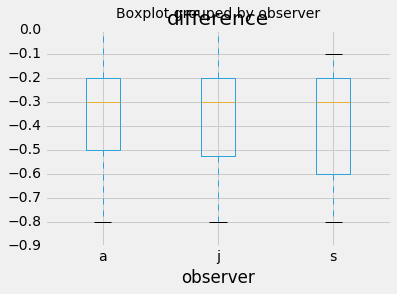

In [31]:
df[df['start_pin_cm'] > 2].boxplot(column='difference', by='observer');

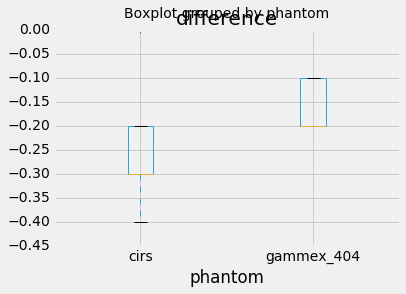

In [32]:
def change_start_pin(x):
    df[df['start_pin_cm'] == x].boxplot(column='difference', by='phantom');
    
interact(change_start_pin, x=widgets.IntSlider(value=4, min=1, max=4));